<a href="https://colab.research.google.com/github/GrinddMaster/My_Grind/blob/main/TransferLearning_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
    _    _ _   _   _                    _
   / \  | (_) | | | |_   _ ___ ___  ___(_)_ __
  / _ \ | | | | |_| | | | / __/ __|/ _ \ | '_ \
 / ___ \| | | |  _  | |_| \__ \__ \  __/ | | | |
/_/   \_\_|_| |_| |_|\__,_|___/___/\___|_|_| |_|

 ____   ___  _  ___   ___  _ __________
|___ \ / _ \/ |/ _ \ / _ \/ |___ /___ /
  __) | | | | | | | | (_) | | |_ \ |_ \
 / __/| |_| | | |_| |\__, | |___) |__) |
|_____|\___/|_|\___/   /_/|_|____/____/
"""

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import cv2
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from concurrent.futures import ThreadPoolExecutor
import plotly.graph_objects as go
from IPython.display import clear_output
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
clear_output(wait=True)



   ID  Disease_Risk  DR  ARMD  MH  DN  MYA  BRVO  TSLN  ERM  ...  CME  PTCR  \
0   1             1   1     0   0   0    0     0     1    0  ...    0     0   
1   2             1   0     0   0   0    0     0     0    0  ...    0     0   
2   3             1   0     0   0   0    0     0     0    0  ...    0     0   
3   4             1   0     0   0   0    0     0     0    0  ...    0     0   
4   5             1   0     0   0   0    0     0     0    0  ...    0     0   

   CF  VH  MCA  VS  BRAO  PLQ  HPED  CL  
0   0   0    0   0     0    0     0   0  
1   0   0    0   0     0    0     0   0  
2   0   0    0   0     0    0     0   0  
3   0   0    0   0     0    0     0   0  
4   0   0    0   0     0    0     0   0  

[5 rows x 47 columns]
(3200, 47)


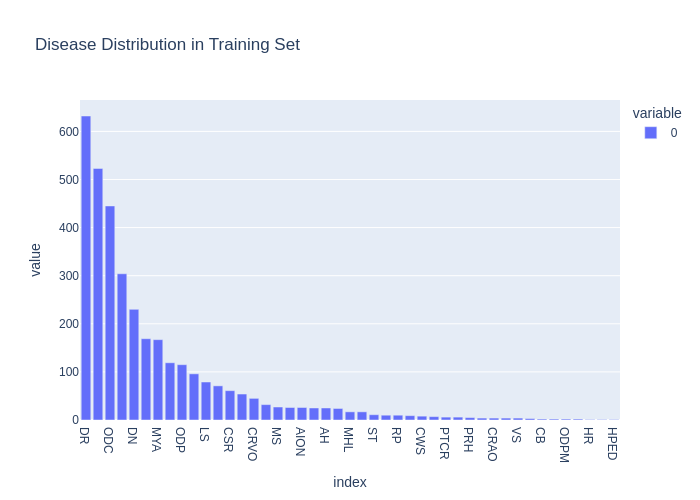

1


In [ ]:
data = pd.read_csv('/kaggle/input/retinal-lables/Labels.csv')
Eval_labels_path = pd.read_csv('/kaggle/input/retinal-disease-classification/Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv')
Test_labels_path = pd.read_csv('/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/RFMiD_Testing_Labels.csv')
Train_labels_path = pd.read_csv('/kaggle/input/retinal-disease-classification/Training_Set/Training_Set/RFMiD_Training_Labels.csv')
print(data.head())

Eval_set_path = '/kaggle/input/retinal-disease-classification/Evaluation_Set/Evaluation_Set/Validation'
Test_set_path = '/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/Test'
Train_set_path = '/kaggle/input/retinal-disease-classification/Training_Set/Training_Set/Training'

print(data.shape)
disease_counts = data.iloc[:, 2:].sum().sort_values(ascending=False)
fig = px.bar(disease_counts, title="Disease Distribution in Training Set")
fig.show(renderer = "png")

count = 1
print(count)
#pip install -U kaleido
#Restart kernel GoTo -> Run -> Restart & ClearSession

In [ ]:

def load_Elabels(img_id):
    labels = []
    for id in img_id['ID']:
        matching_row = Eval_labels_path[Eval_labels_path['ID']==id]
        if not matching_row.empty:
            row = Eval_labels_path[Eval_labels_path['ID'] == id].iloc[0]
            labels.append(row['Disease_Risk'])
        else:
            print(f'{id} isnt found')
    return np.array(labels)
def load_Telabels(img_id):
    labels = []
    for id in img_id['ID']:
        matching_row = Test_labels_path[Test_labels_path['ID']==id]
        if not matching_row.empty:
            row = Eval_labels_path[Eval_labels_path['ID'] == id].iloc[0]
            labels.append(row['Disease_Risk'])
        else:
            print(f'{id} isnt found')
    return np.array(labels)
def load_Trlabels(img_id):
    labels = []
    for id in img_id['ID']:
        matching_row = Train_labels_path[Train_labels_path['ID']==id]
        if not matching_row.empty:
            row = Train_labels_path[Train_labels_path['ID'] == id].iloc[0]
            labels.append(row['Disease_Risk'])
        else:
            print(f'{id} isnt found')
    return np.array(labels)
print('Hello world')
Eval_labels = load_Elabels(Eval_labels_path)
print(Eval_labels.shape)
Test_labels = load_Telabels(Test_labels_path)
print(Test_labels.shape)
Train_labels = load_Trlabels(Train_labels_path)
print(Train_labels.shape)

Ytrain = np.concatenate((Eval_labels,Test_labels,Train_labels))
print(Ytrain.shape)
#Now all the images and Lables are in Xtrain

Hello world
(640,)
(640,)
(1920,)
(3200,)


In [ ]:
testgen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode='nearest'
)

In [ ]:
def load_images(img_id,img_path):#this function returns all the images and lables in one big array
    images = []
    for id in img_id['ID']:
        full_img_path = os.path.join(img_path, f"{id}.png")
        if os.path.exists(full_img_path):
            img = cv2.imread(full_img_path)
            if img is not None:
                img = cv2.resize(img,(246,246))
                images.append(img)
    return np.array(images)

Eval_images = load_images(Eval_labels_path,Eval_set_path)
Test_images = load_images(Test_labels_path,Test_set_path)
Train_images = load_images(Train_labels_path,Train_set_path)
Xtrain = np.concatenate((Eval_images,Test_images,Train_images))
print(Xtrain.shape)
#Now all the iamges and Lables are in Xtrain

(3200, 246, 246, 3)


In [ ]:
Xtrain = Xtrain/255.0 #Normalize the data.
augmented_test = testgen.flow(Test_images,Test_labels,shuffle=True)

In [ ]:

kf = KFold(n_splits=5)
fold_no = 1
for train_index, val_index in kf.split(Xtrain):
    Xtrain_fold,Xval_fold = Xtrain[train_index],Xtrain[val_index]
    Ytrain_fold,Yval_fold = Ytrain[train_index],Ytrain[val_index]
    print(f'Training fold {fold_no}...')

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(246, 246, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(47, activation='relu')(x)
    x = Dense(120, activation='relu')(x)
    x = Dense(200, activation='relu')(x)
    x = Dense(80, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    for layers in base_model.layers:
        layers.trainable = False

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    history=model.fit(Xtrain_fold, Ytrain_fold, epochs=50, validation_data=(Xval_fold, Yval_fold))

    fold_no += 1


Training fold 1...
Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 30s 201ms/step - accuracy: 0.7813 - loss: 0.5504 - val_accuracy: 0.7906 - val_loss: 0.5125
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 0.7982 - loss: 0.4983 - val_accuracy: 0.7906 - val_loss: 0.5106
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 158ms/step - accuracy: 0.7977 - loss: 0.4984 - val_accuracy: 0.7906 - val_loss: 0.5033
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 165ms/step - accuracy: 0.8122 - loss: 0.4723 - val_accuracy: 0.7906 - val_loss: 0.5322
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step - accuracy: 0.7952 - loss: 0.4969 - val_accuracy: 0.7906 - val_loss: 0.4980
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 153ms/step - accuracy: 0.7931 - loss: 0.4907 - val_accuracy: 0.7906 - val_loss: 0.5020
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.8024 - loss: 0.4839 - val_accuracy: 0.7906 - val_loss: 0.4961
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - accuracy: 0.7988 - loss

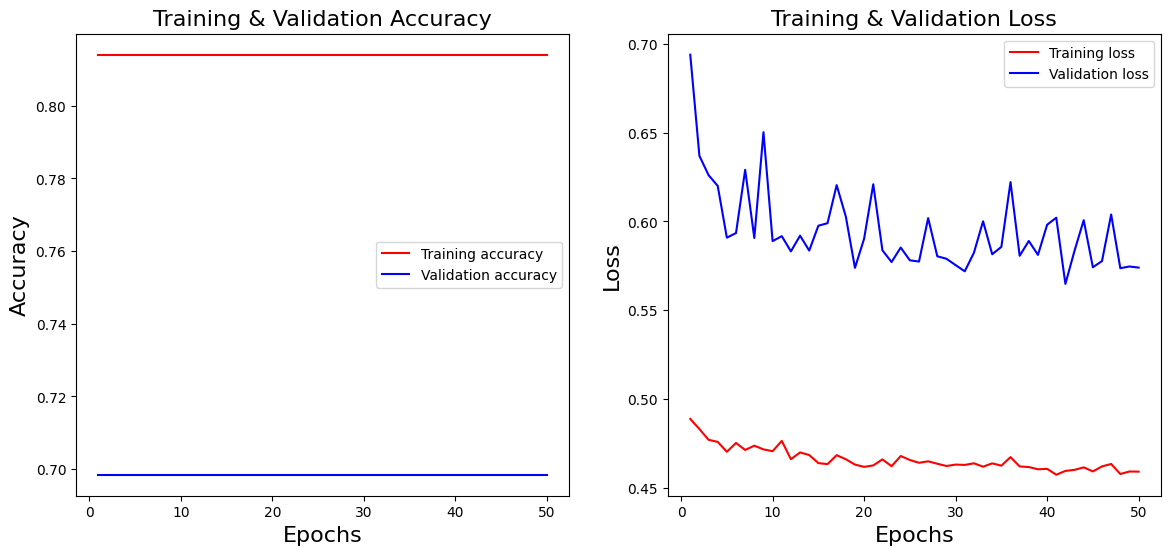

In [ ]:

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'r', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'r', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

In [ ]:

y_pred = (model.predict(augmented_test) > 0.5).astype("int32")

print("Accuracy:", accuracy_score(Test_labels, y_pred))
print("Classification Report:")
print(classification_report(Test_labels, y_pred))

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 329ms/step
Accuracy: 0.790625
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       134
           1       0.79      1.00      0.88       506

    accuracy                           0.79       640
   macro avg       0.40      0.50      0.44       640
weighted avg       0.63      0.79      0.70       640



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



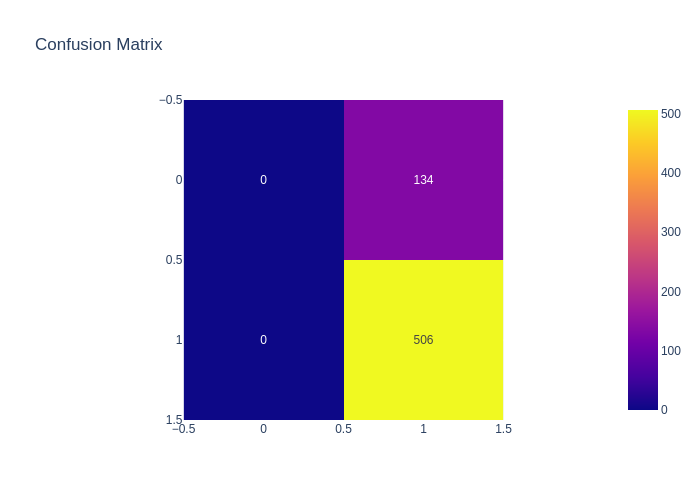

In [ ]:
cm = confusion_matrix(Test_labels, y_pred)
fig = px.imshow(cm, text_auto=True, title="Confusion Matrix")
fig.show(renderer = "png")

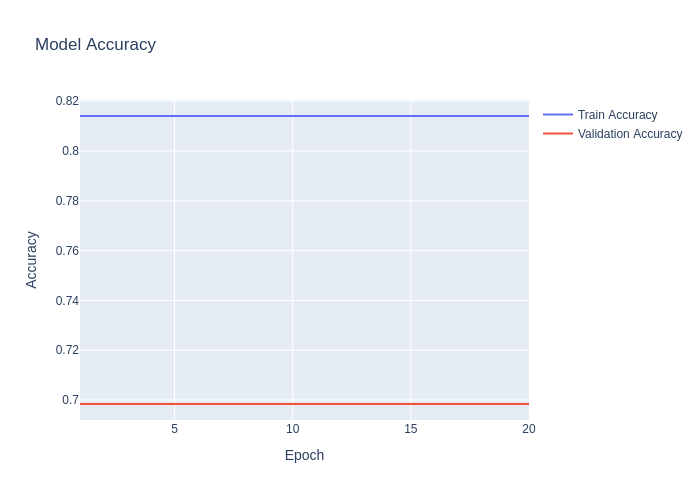

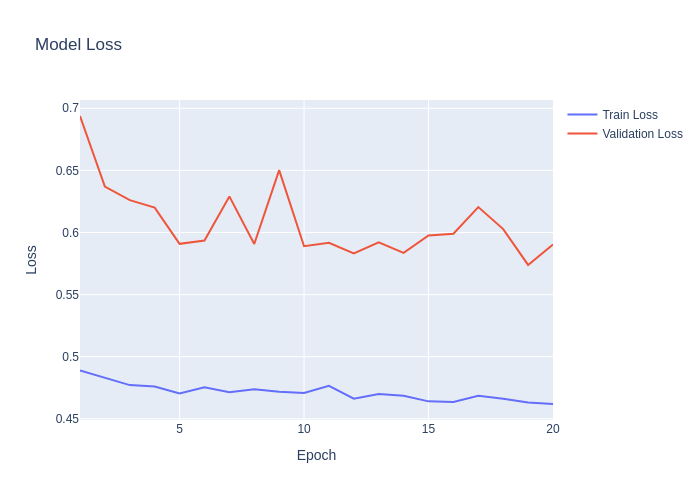

In [ ]:
# Plot training history
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, 21)), y=history.history['accuracy'], mode='lines', name='Train Accuracy'))
fig.add_trace(go.Scatter(x=list(range(1, 21)), y=history.history['val_accuracy'], mode='lines', name='Validation Accuracy'))
fig.update_layout(title='Model Accuracy', xaxis_title='Epoch', yaxis_title='Accuracy')
fig.show(renderer="png")

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, 21)), y=history.history['loss'], mode='lines', name='Train Loss'))
fig.add_trace(go.Scatter(x=list(range(1, 21)), y=history.history['val_loss'], mode='lines', name='Validation Loss'))
fig.update_layout(title='Model Loss', xaxis_title='Epoch', yaxis_title='Loss')
fig.show(renderer="png")